In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import time
from torchvision import transforms
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define the VisualProcessor model class
class VisualProcessor(nn.Module):
    def __init__(self, num_classes=5):
        super(VisualProcessor, self).__init__()

        # Load Swin V2 Tiny models for RGB and Depth
        from torchvision.models import swin_v2_t, Swin_V2_T_Weights
        weights = Swin_V2_T_Weights.IMAGENET1K_V1

        # Create RGB model
        self.rgb_model = swin_v2_t(weights=weights)
        # Create Depth model
        self.depth_model = swin_v2_t(weights=weights)

        # Remove the classification heads
        feature_dim = self.rgb_model.head.in_features  # This is 768 for Swin V2 Tiny
        self.rgb_model.head = nn.Identity()
        self.depth_model.head = nn.Identity()

        # Define feature dimensions for each stage
        # Swin V2 Tiny has 4 stages with dimensions: [96, 192, 384, 768]
        self.stage_dims = [96, 192, 384, 768]

        # Create feature extraction dictionaries for each stage
        self.rgb_features = {}
        self.depth_features = {}

        # Feature mixer modules for each stage (RGB + Depth only)
        self.stage_mixers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(dim*2, dim),  # RGB + Depth
                nn.LayerNorm(dim),
                nn.GELU()
            ) for dim in self.stage_dims
        ])

        # Feature projectors to common dimension
        self.stage_projectors = nn.ModuleList([
            nn.Sequential(
                nn.Linear(dim, 128),
                nn.GELU()
            ) for dim in self.stage_dims
        ])

        # Final prediction head
        self.prediction_head = nn.Sequential(
            nn.Linear(128*4, 256),  # 4 stages with 128-dim projections
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

        # Register hooks to get intermediate features
        self._register_hooks()

    def _register_hooks(self):
        """Register hooks to extract features from each stage"""

        def get_hook(stage_name, feature_dict):
            def hook(module, input, output):
                # For Swin, we perform global average pooling on the output
                # Output shape is [B, H, W, C] -> Pooled shape is [B, C]
                # First permute to [B, C, H, W] for pooling
                pooled = output.permute(0, 3, 1, 2)
                pooled = F.adaptive_avg_pool2d(pooled, 1).flatten(1)
                feature_dict[stage_name] = pooled

                # Also store the original spatial output for GradCAM
                feature_dict[stage_name + "_spatial"] = output
            return hook

        # Register hooks for RGB backbone
        self.rgb_model.features[1].register_forward_hook(get_hook("stage0", self.rgb_features))  # First stage
        self.rgb_model.features[3].register_forward_hook(get_hook("stage1", self.rgb_features))  # Second stage
        self.rgb_model.features[5].register_forward_hook(get_hook("stage2", self.rgb_features))  # Third stage
        self.rgb_model.features[7].register_forward_hook(get_hook("stage3", self.rgb_features))  # Fourth stage

        # Register hooks for Depth backbone
        self.depth_model.features[1].register_forward_hook(get_hook("stage0", self.depth_features))  # First stage
        self.depth_model.features[3].register_forward_hook(get_hook("stage1", self.depth_features))  # Second stage
        self.depth_model.features[5].register_forward_hook(get_hook("stage2", self.depth_features))  # Third stage
        self.depth_model.features[7].register_forward_hook(get_hook("stage3", self.depth_features))  # Fourth stage

    def forward(self, rgb, depth):
        # Forward pass through RGB model
        _ = self.rgb_model(rgb)

        # Forward pass through Depth model
        _ = self.depth_model(depth)

        # Collect and mix features from each stage
        mixed_features = []

        for i in range(4):  # 4 stages
            stage_name = f"stage{i}"

            # Get RGB and Depth features
            rgb_feat = self.rgb_features[stage_name]
            depth_feat = self.depth_features[stage_name]

            # Concatenate RGB and Depth features
            concat_feat = torch.cat([rgb_feat, depth_feat], dim=1)

            # Mix features
            mixed_feat = self.stage_mixers[i](concat_feat)

            # Project to common dimension
            projected_feat = self.stage_projectors[i](mixed_feat)

            mixed_features.append(projected_feat)

        # Concatenate all mixed features for final prediction
        all_features = torch.cat(mixed_features, dim=1)

        # Final prediction
        predictions = self.prediction_head(all_features)

        # Return predictions and final visual features
        final_visual_features = self.rgb_features["stage3"]  # Use final stage RGB features
        
        return predictions, final_visual_features

In [3]:
class SwinTransformerGradCAM:
    """
    GradCAM implementation for Swin Transformer V2 models used in nutrition prediction
    """
    def __init__(self, model, use_rgb=True):
        self.model = model
        self.use_rgb = use_rgb
        
        # Dictionary to store gradients
        self.gradients = {}
        
        # Register hooks to capture gradients
        self._register_hooks()
        
        # Set model to evaluation mode
        self.model.eval()
    
    def _register_hooks(self):
        """Register backward hooks to capture gradients"""
        
        def save_gradients(name):
            def hook(module, grad_input, grad_output):
                # Store the gradients for later use
                self.gradients[name] = grad_output[0]
            return hook
        
        # Register backward hooks on stage3 (final stage)
        if self.use_rgb:
            # For RGB path
            self.model.rgb_model.features[7].register_backward_hook(save_gradients("rgb_stage3"))
        else:
            # For depth path
            self.model.depth_model.features[7].register_backward_hook(save_gradients("depth_stage3"))
    
    def _compute_gradcam(self, feature_map, gradients, target_size=None):
        """Compute GradCAM activation map"""
        # Convert features to the right format
        # For Swin Transformer, feature maps are [B, H, W, C] -> [B, C, H, W]
        feature_map = feature_map.permute(0, 3, 1, 2)
        gradients = gradients.permute(0, 3, 1, 2)
        
        # Compute weights: global average pooling of gradients
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)  # [B, C, 1, 1]
        
        # Weighted sum of feature maps
        cam = torch.sum(weights * feature_map, dim=1, keepdim=True)  # [B, 1, H, W]
        
        # Apply ReLU to focus on features positively influencing the target
        cam = F.relu(cam)
        
        # Normalize each CAM separately
        for i in range(cam.size(0)):
            cam[i] = cam[i] - cam[i].min()
            if cam[i].max() > 0:
                cam[i] = cam[i] / cam[i].max()
        
        # Resize to target size if specified
        if target_size is not None:
            cam = F.interpolate(cam, size=target_size, mode='bilinear', align_corners=False)
        
        return cam
    
    def generate_nutrient_cam(self, rgb_img, depth_img, nutrient_idx=0, target_size=(256, 256), skip_normalize=False):
        """Generate GradCAM for a specific nutrient prediction"""
        # Ensure we're working with batched inputs
        if rgb_img.dim() == 3:
            rgb_img = rgb_img.unsqueeze(0)
        if depth_img.dim() == 3:
            depth_img = depth_img.unsqueeze(0)
        
        # Forward pass
        self.model.zero_grad()
        
        # Clear gradient dictionary
        self.gradients = {}
        
        # Get predictions
        predictions, _ = self.model(rgb_img, depth_img)
        
        # Target for backprop is the specific nutrient score
        target = predictions[0, nutrient_idx]
        
        # Backward pass (compute gradients)
        target.backward(retain_graph=True)
        
        # Get feature maps from hooks - focusing only on stage3
        if self.use_rgb:
            feature_maps = self.model.rgb_features["stage3_spatial"]
            gradients = self.gradients.get("rgb_stage3")
        else:
            feature_maps = self.model.depth_features["stage3_spatial"]
            gradients = self.gradients.get("depth_stage3")
        
        if gradients is None:
            raise ValueError("No gradients found. Make sure backward pass was executed.")
        
        # For special analysis, we might want to skip normalization
        if skip_normalize:
            # Directly compute CAM without normalization
            # Convert features to the right format
            feature_map = feature_maps.permute(0, 3, 1, 2)
            grads = gradients.permute(0, 3, 1, 2)
            
            # Compute weights
            weights = torch.mean(grads, dim=(2, 3), keepdim=True)
            
            # Weighted sum of feature maps
            cam = torch.sum(weights * feature_map, dim=1, keepdim=True)
            
            # Apply ReLU
            cam = F.relu(cam)
            
            # Resize if needed
            if target_size is not None:
                cam = F.interpolate(cam, size=target_size, mode='bilinear', align_corners=False)
                
            # Convert to numpy array without normalization
            cam = cam.cpu().detach().numpy()[0, 0]
            return cam, predictions.detach().cpu().numpy()[0]
        
        # Compute GradCAM
        cam = self._compute_gradcam(feature_maps, gradients, target_size)
        
        # Convert to numpy array
        cam = cam.cpu().detach().numpy()[0, 0]
        
        return cam, predictions.detach().cpu().numpy()[0]

In [4]:
def load_and_preprocess_images(rgb_path, depth_path):
    """Load and preprocess RGB and depth images"""
    # Constants
    DEPTH_CLIPPING_FLAG = 1
    IMAGE_SIZE_BEFORE_CROP = 260
    IMAGE_SIZE = 256
    
    # Load original RGB image
    original_rgb = Image.open(rgb_path).convert('RGB')
    rgb_np = np.array(original_rgb)
    
    # Load depth image (uint16 format)
    depth_img = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)  # uint16 format
    
    if DEPTH_CLIPPING_FLAG == 1:
        # Trim values ≥ 4000 to 4000
        depth_img = np.clip(depth_img, 0, 4000)
        # Normalize depth to 0-255 for easier processing
        depth_img = (depth_img / 4000.0 * 255).astype(np.uint8)
    else:
        max_depth = np.max(depth_img)
        if max_depth == 0:  # Avoid division by zero
            max_depth = 1
        depth_img = (depth_img / max_depth * 255).astype(np.uint8)
    
    # Convert single-channel depth to 3-channel by repeating
    depth_img_3channel = np.stack([depth_img, depth_img, depth_img], axis=2)
    
    # Save original depth image for later use
    original_depth = Image.fromarray(depth_img_3channel.copy())
    
    # Convert to PIL Image for transformation
    rgb_img = Image.fromarray(rgb_np)
    depth_img = Image.fromarray(depth_img_3channel)
    
    # Define transformations for model input
    transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE_BEFORE_CROP, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Apply transformations
    rgb_tensor = transform(rgb_img)
    depth_tensor = transform(depth_img)
    
    return original_rgb, original_depth, rgb_tensor, depth_tensor

def apply_heatmap(img, heatmap, alpha=0.5):
    """Apply heatmap overlay to an image"""
    # Convert heatmap to RGB colormap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Ensure image is in RGB format and uint8 type
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).numpy()  # Convert [C, H, W] -> [H, W, C]
        img = (img * 255).astype(np.uint8)
    elif isinstance(img, Image.Image):
        img = np.array(img)
    
    # Resize heatmap to match image dimensions if needed
    if img.shape[:2] != heatmap_colored.shape[:2]:
        heatmap_colored = cv2.resize(heatmap_colored, (img.shape[1], img.shape[0]))
    
    # Blend image with heatmap
    blended = cv2.addWeighted(img, 1-alpha, heatmap_colored, alpha, 0)
    
    return blended

In [5]:
# Update these paths to your specific locations
MODEL_PATH = '/home/yif22003/generic_food/code_results/Ablation_studies/040625_Full_Model/best_model.pth'
# Example dish for testing
dish_id_str = "dish_1558028194"
rgb_path = f"/home/yif22003/generic_food/nutrition5k_rgbd/{dish_id_str}/rgb.png"
depth_path = f"/home/yif22003/generic_food/nutrition5k_rgbd/{dish_id_str}/depth_raw.png"

# Load images
original_rgb, original_depth, rgb_tensor, depth_tensor = load_and_preprocess_images(rgb_path, depth_path)

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = VisualProcessor().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# Move tensors to device
rgb_tensor = rgb_tensor.to(device)
depth_tensor = depth_tensor.to(device)

Using device: cpu


In [6]:
# Create GradCAM instances
rgb_gradcam = SwinTransformerGradCAM(model, use_rgb=True)
depth_gradcam = SwinTransformerGradCAM(model, use_rgb=False)

nutrient_names = ['Calories', 'Mass', 'Fat', 'Carb', 'Protein']
depth_raw_cams = []
rgb_raw_cams = []
predictions = None

# Generate raw GradCAM values for each nutrient (without normalization)
for i, name in enumerate(nutrient_names):
    # Generate raw RGB GradCAM without normalization
    rgb_cam, preds = rgb_gradcam.generate_nutrient_cam(
        rgb_tensor.unsqueeze(0), depth_tensor.unsqueeze(0), 
        nutrient_idx=i, skip_normalize=True
    )
    rgb_raw_cams.append(rgb_cam)
    
    # Generate raw depth GradCAM without normalization
    depth_cam, preds = depth_gradcam.generate_nutrient_cam(
        rgb_tensor.unsqueeze(0), depth_tensor.unsqueeze(0), 
        nutrient_idx=i, skip_normalize=True
    )
    depth_raw_cams.append(depth_cam)
    
    # Save predictions from the first run
    if i == 0:
        predictions = preds

# Let's analyze the statistical properties of the GradCAM values
depth_stats = []
rgb_stats = []

for i, name in enumerate(nutrient_names):
    rgb_cam = rgb_raw_cams[i]
    depth_cam = depth_raw_cams[i]
    
    # Compute statistics for RGB CAM
    rgb_min = np.min(rgb_cam)
    rgb_max = np.max(rgb_cam)
    rgb_mean = np.mean(rgb_cam)
    rgb_std = np.std(rgb_cam)
    rgb_range = rgb_max - rgb_min
    
    # Compute statistics for depth CAM
    depth_min = np.min(depth_cam)
    depth_max = np.max(depth_cam)
    depth_mean = np.mean(depth_cam)
    depth_std = np.std(depth_cam)
    depth_range = depth_max - depth_min
    
    rgb_stats.append({
        'min': rgb_min,
        'max': rgb_max,
        'mean': rgb_mean,
        'std': rgb_std,
        'range': rgb_range
    })
    
    depth_stats.append({
        'min': depth_min,
        'max': depth_max,
        'mean': depth_mean,
        'std': depth_std,
        'range': depth_range
    })

# Print statistics
print("Predictions:", predictions)
print("\nStatistics for RGB GradCAM values:")
for i, name in enumerate(nutrient_names):
    print(f"{name}: Min={rgb_stats[i]['min']:.6f}, Max={rgb_stats[i]['max']:.6f}, Mean={rgb_stats[i]['mean']:.6f}, Std={rgb_stats[i]['std']:.6f}, Range={rgb_stats[i]['range']:.6f}")

print("\nStatistics for Depth GradCAM values:")
for i, name in enumerate(nutrient_names):
    print(f"{name}: Min={depth_stats[i]['min']:.6f}, Max={depth_stats[i]['max']:.6f}, Mean={depth_stats[i]['mean']:.6f}, Std={depth_stats[i]['std']:.6f}, Range={depth_stats[i]['range']:.6f}")

Predictions: [231.09291  164.43336   11.848458  23.870289  10.066575]

Statistics for RGB GradCAM values:
Calories: Min=0.000000, Max=2.829882, Mean=0.370719, Std=0.742781, Range=2.829882
Mass: Min=0.000000, Max=1.350777, Mean=0.182167, Std=0.288400, Range=1.350777
Fat: Min=0.000000, Max=0.492761, Mean=0.057324, Std=0.128300, Range=0.492761
Carb: Min=0.000000, Max=0.468445, Mean=0.094704, Std=0.121250, Range=0.468445
Protein: Min=0.000000, Max=0.281485, Mean=0.033745, Std=0.072763, Range=0.281485

Statistics for Depth GradCAM values:
Calories: Min=0.290570, Max=0.319563, Mean=0.304302, Std=0.006582, Range=0.028993
Mass: Min=0.248866, Max=0.264565, Mean=0.257100, Std=0.003587, Range=0.015698
Fat: Min=0.018361, Max=0.021452, Mean=0.019857, Std=0.000678, Range=0.003091
Carb: Min=0.000000, Max=0.000000, Mean=0.000000, Std=0.000000, Range=0.000000
Protein: Min=0.049247, Max=0.054151, Mean=0.051527, Std=0.001112, Range=0.004904


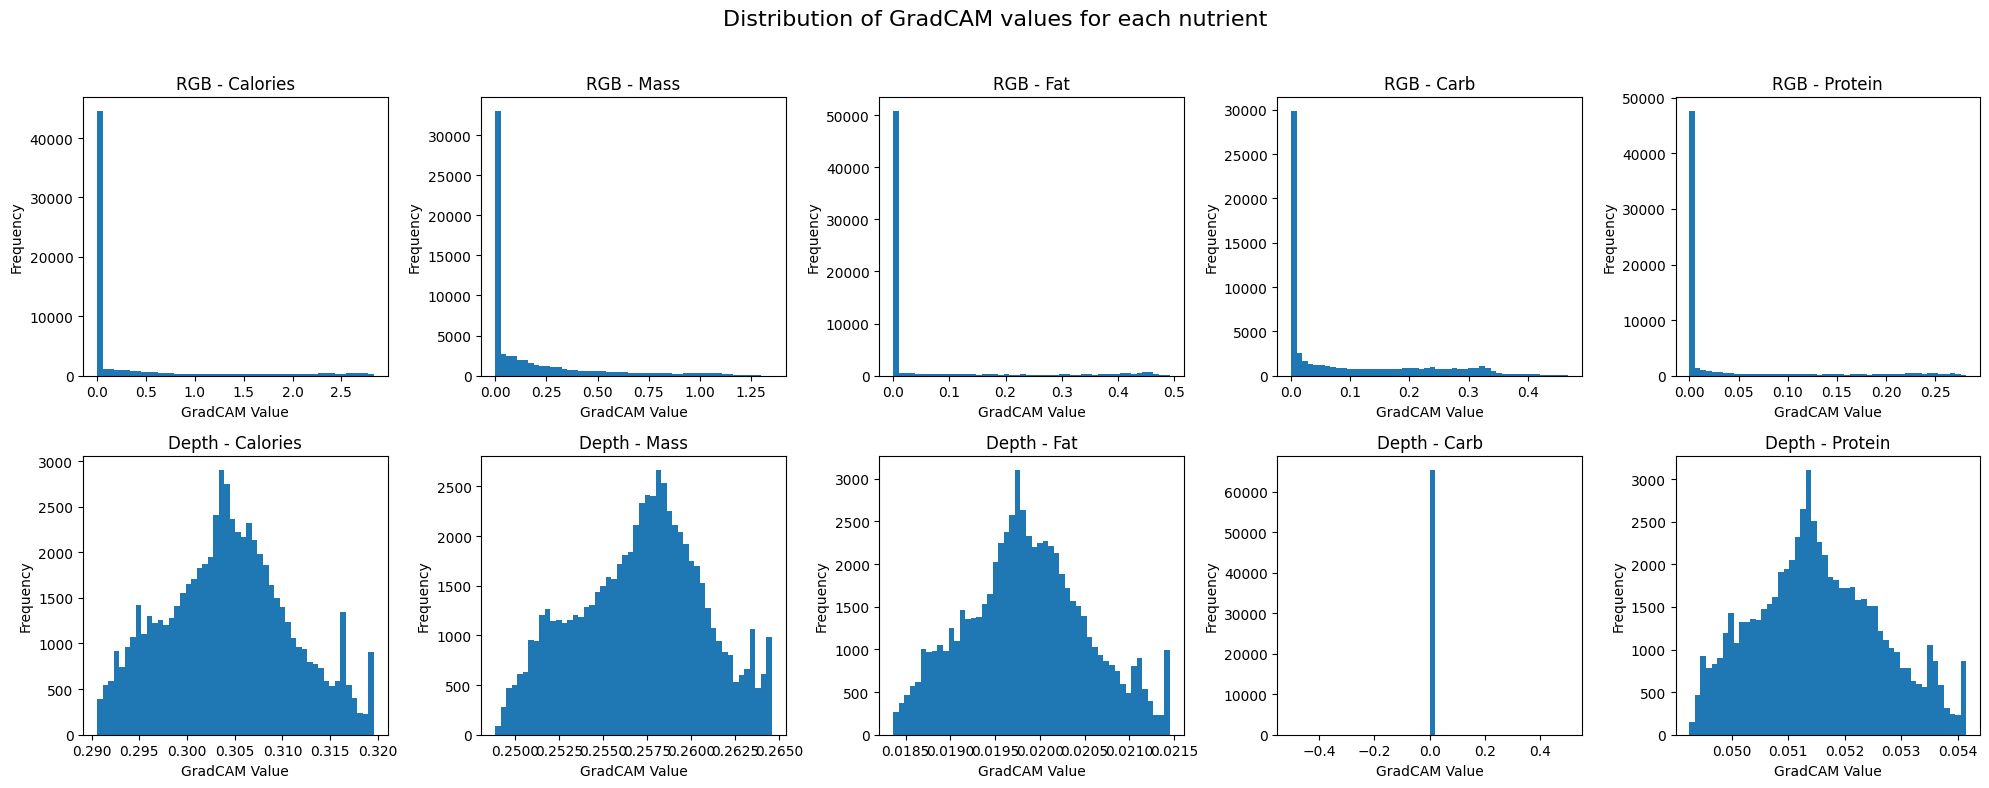

In [7]:
# Create histograms of raw GradCAM values for each nutrient
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Distribution of GradCAM values for each nutrient', fontsize=16)

for i, name in enumerate(nutrient_names):
    # RGB histogram
    axes[0, i].hist(rgb_raw_cams[i].flatten(), bins=50)
    axes[0, i].set_title(f'RGB - {name}')
    axes[0, i].set_xlabel('GradCAM Value')
    axes[0, i].set_ylabel('Frequency')
    
    # Depth histogram
    axes[1, i].hist(depth_raw_cams[i].flatten(), bins=50)
    axes[1, i].set_title(f'Depth - {name}')
    axes[1, i].set_xlabel('GradCAM Value')
    axes[1, i].set_ylabel('Frequency')
    
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

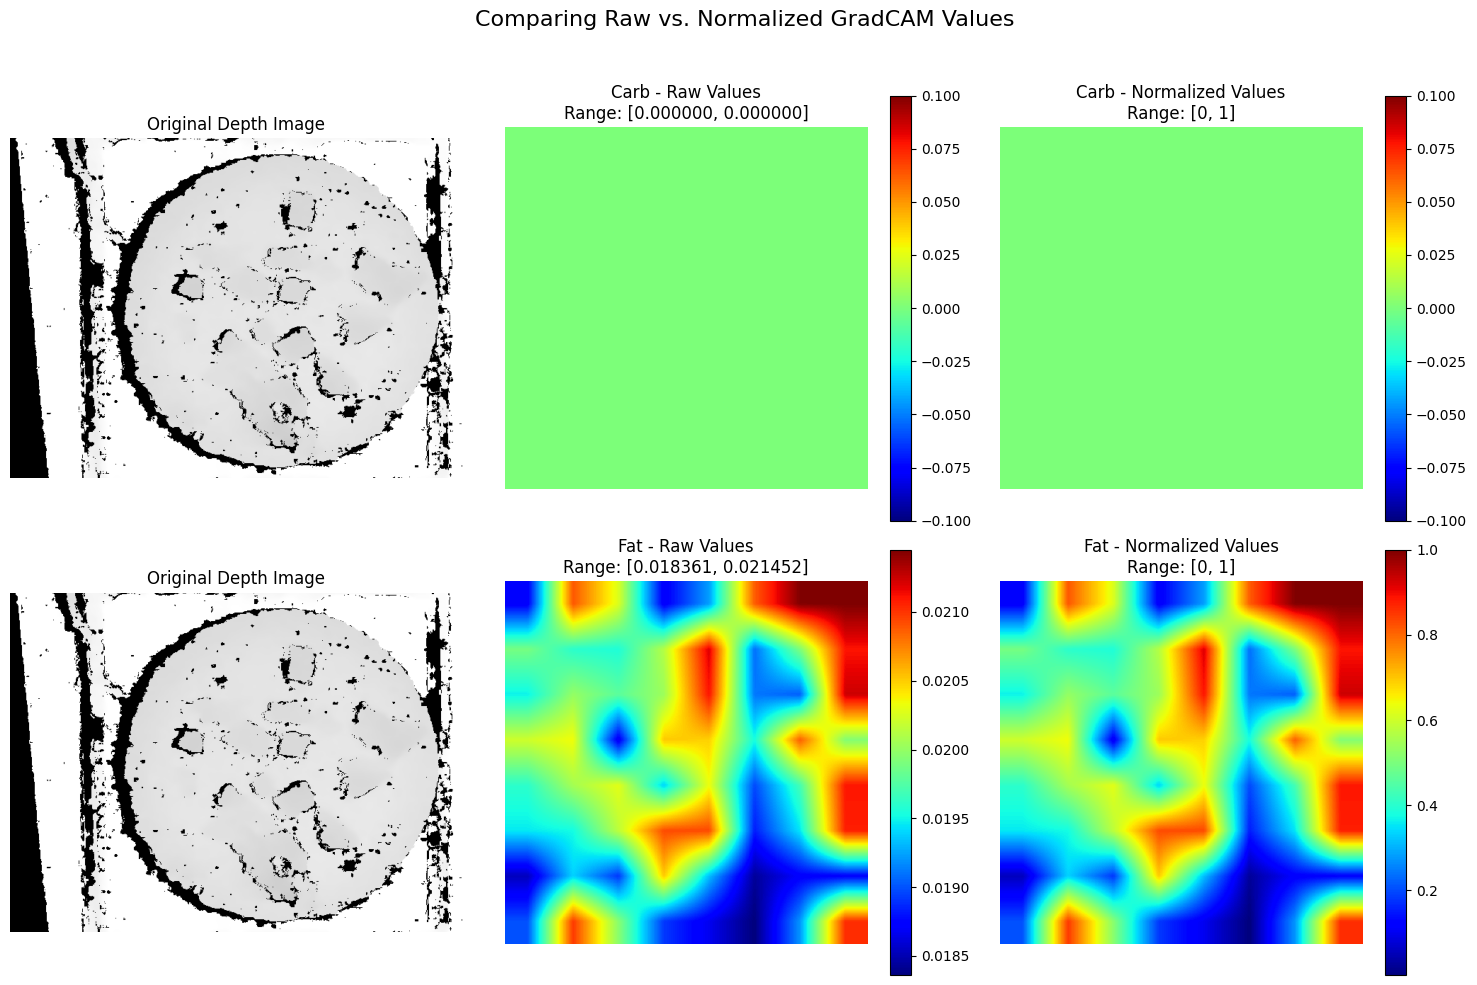

In [8]:
# Generate normalized GradCAM for comparison
normalized_depth_cams = []

for i, name in enumerate(nutrient_names):
    # Generate depth GradCAM with standard normalization
    depth_cam, _ = depth_gradcam.generate_nutrient_cam(
        rgb_tensor.unsqueeze(0), depth_tensor.unsqueeze(0), 
        nutrient_idx=i, skip_normalize=False
    )
    normalized_depth_cams.append(depth_cam)

# Compare raw and normalized GradCAM for carbs and fat
carb_idx = 3  # Index for carbohydrates
fat_idx = 2   # Index for fat

# Create figure for comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Comparing Raw vs. Normalized GradCAM Values', fontsize=16)

# Show raw depth CAM for carbohydrates
depth_np = np.array(original_depth)
axes[0, 0].imshow(depth_np)
axes[0, 0].set_title('Original Depth Image')
axes[0, 0].axis('off')

# Normalize raw depth CAM for carbohydrates (manually)
raw_carb_cam = depth_raw_cams[carb_idx].copy()
if np.max(raw_carb_cam) > np.min(raw_carb_cam):
    manual_norm_carb = (raw_carb_cam - np.min(raw_carb_cam)) / (np.max(raw_carb_cam) - np.min(raw_carb_cam))
else:
    manual_norm_carb = raw_carb_cam

# Show carb raw values using colormap
im = axes[0, 1].imshow(raw_carb_cam, cmap='jet')
axes[0, 1].set_title(f'Carb - Raw Values\nRange: [{np.min(raw_carb_cam):.6f}, {np.max(raw_carb_cam):.6f}]')
axes[0, 1].axis('off')
plt.colorbar(im, ax=axes[0, 1])

# Show carb normalized values
im = axes[0, 2].imshow(normalized_depth_cams[carb_idx], cmap='jet')
axes[0, 2].set_title(f'Carb - Normalized Values\nRange: [0, 1]')
axes[0, 2].axis('off')
plt.colorbar(im, ax=axes[0, 2])

# Show raw depth CAM for fat
axes[1, 0].imshow(depth_np)
axes[1, 0].set_title('Original Depth Image')
axes[1, 0].axis('off')

# Show fat raw values using colormap
im = axes[1, 1].imshow(depth_raw_cams[fat_idx], cmap='jet')
axes[1, 1].set_title(f'Fat - Raw Values\nRange: [{np.min(depth_raw_cams[fat_idx]):.6f}, {np.max(depth_raw_cams[fat_idx]):.6f}]')
axes[1, 1].axis('off')
plt.colorbar(im, ax=axes[1, 1])

# Show fat normalized values
im = axes[1, 2].imshow(normalized_depth_cams[fat_idx], cmap='jet')
axes[1, 2].set_title(f'Fat - Normalized Values\nRange: [0, 1]')
axes[1, 2].axis('off')
plt.colorbar(im, ax=axes[1, 2])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

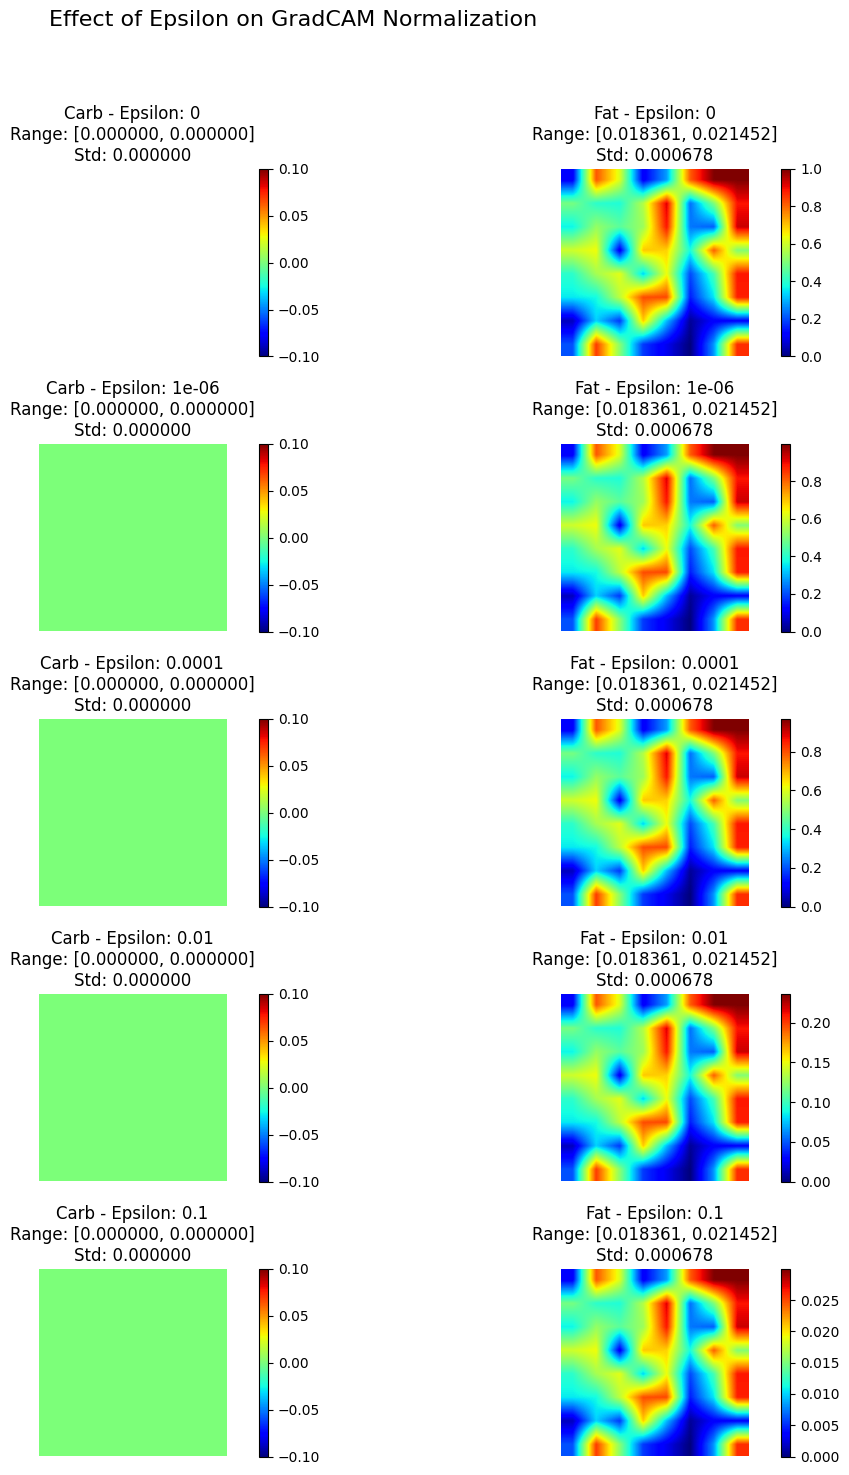

In [9]:
# Create a custom normalization function with epsilon
def normalize_with_epsilon(cam, epsilon=1e-5):
    """Normalize CAM values with an epsilon to avoid division by zero"""
    cam_min = np.min(cam)
    cam_max = np.max(cam)
    
    # Add epsilon to the range
    norm_cam = (cam - cam_min) / (cam_max - cam_min + epsilon)
    return norm_cam

# Try different epsilon values
epsilon_values = [0, 1e-6, 1e-4, 1e-2, 1e-1]

# Create figure
fig, axes = plt.subplots(len(epsilon_values), 2, figsize=(12, 15))
fig.suptitle('Effect of Epsilon on GradCAM Normalization', fontsize=16)

for i, epsilon in enumerate(epsilon_values):
    # Normalize carb CAM with current epsilon
    carb_norm = normalize_with_epsilon(depth_raw_cams[carb_idx], epsilon)
    
    # Normalize fat CAM with current epsilon
    fat_norm = normalize_with_epsilon(depth_raw_cams[fat_idx], epsilon)
    
    # Display normalized carb CAM
    im1 = axes[i, 0].imshow(carb_norm, cmap='jet')
    axes[i, 0].set_title(f'Carb - Epsilon: {epsilon}\nRange: [{depth_stats[carb_idx]["min"]:.6f}, {depth_stats[carb_idx]["max"]:.6f}]\nStd: {depth_stats[carb_idx]["std"]:.6f}')
    axes[i, 0].axis('off')
    plt.colorbar(im1, ax=axes[i, 0])
    
    # Display normalized fat CAM
    im2 = axes[i, 1].imshow(fat_norm, cmap='jet')
    axes[i, 1].set_title(f'Fat - Epsilon: {epsilon}\nRange: [{depth_stats[fat_idx]["min"]:.6f}, {depth_stats[fat_idx]["max"]:.6f}]\nStd: {depth_stats[fat_idx]["std"]:.6f}')
    axes[i, 1].axis('off')
    plt.colorbar(im2, ax=axes[i, 1])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Relative Importance of RGB vs. Depth Information:
Calories: RGB=54.92%, Depth=45.08%
Mass: RGB=41.47%, Depth=58.53%
Fat: RGB=74.27%, Depth=25.73%
Carb: RGB=100.00%, Depth=0.00%
Protein: RGB=39.57%, Depth=60.43%


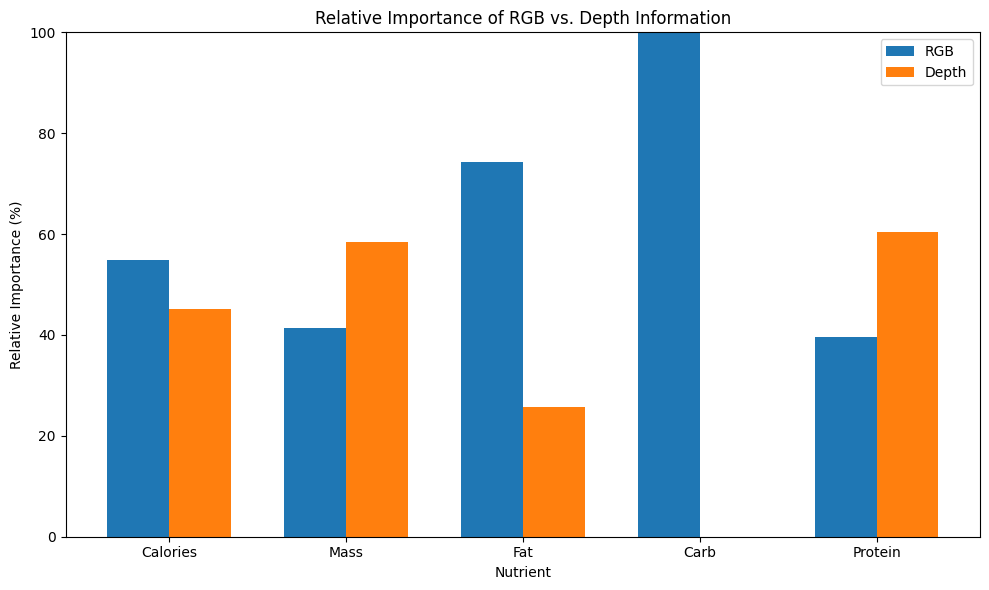

In [10]:
# Compute relative importance of depth vs. RGB information
relative_importance = []

for i, name in enumerate(nutrient_names):
    # Calculate total magnitude of RGB GradCAM
    rgb_magnitude = np.sum(np.abs(rgb_raw_cams[i]))
    
    # Calculate total magnitude of depth GradCAM
    depth_magnitude = np.sum(np.abs(depth_raw_cams[i]))
    
    # Compute relative importance
    total_magnitude = rgb_magnitude + depth_magnitude
    depth_importance = depth_magnitude / total_magnitude if total_magnitude > 0 else 0
    rgb_importance = rgb_magnitude / total_magnitude if total_magnitude > 0 else 0
    
    relative_importance.append({
        'nutrient': name,
        'rgb_magnitude': rgb_magnitude,
        'depth_magnitude': depth_magnitude,
        'rgb_importance': rgb_importance,
        'depth_importance': depth_importance
    })

# Print and visualize relative importance
print("Relative Importance of RGB vs. Depth Information:")
for item in relative_importance:
    print(f"{item['nutrient']}: RGB={item['rgb_importance']*100:.2f}%, Depth={item['depth_importance']*100:.2f}%")

# Visualize relative importance
plt.figure(figsize=(10, 6))
labels = [item['nutrient'] for item in relative_importance]
rgb_values = [item['rgb_importance'] * 100 for item in relative_importance]
depth_values = [item['depth_importance'] * 100 for item in relative_importance]

x = np.arange(len(labels))
width = 0.35

plt.bar(x - width/2, rgb_values, width, label='RGB')
plt.bar(x + width/2, depth_values, width, label='Depth')

plt.xlabel('Nutrient')
plt.ylabel('Relative Importance (%)')
plt.title('Relative Importance of RGB vs. Depth Information')
plt.xticks(x, labels)
plt.ylim(0, 100)
plt.legend()

plt.tight_layout()
plt.show()